# Import Librerie

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Definizione funzioni

In [2]:
def RMSE_Loss(actual, predicted):
    """Root Mean Squared Error"""
    return np.sqrt(np.mean(np.square(actual - predicted)))

In [3]:
def getRemoteDataset():
    return pd.read_csv('https://raw.githubusercontent.com/Uniba-dev-projects/forecasting-framework/synthetic_dataset_analysis/synthetic_dataset/synthetic_dataset.csv')    

In [8]:
def extractDataframeAndSeries(key, dataset):
    df = dataset[[key]]
    df = df.rename(columns={key: "t"}).reset_index()
    df.series = df.t.str.replace(",",".", regex=True).astype(np.float32)
    return df, df.series.squeeze().dropna()

In [4]:
def calculateResiduals(y, y_predicted):
    loss = []
    for i in range(len(y)):
        loss.append(abs(y[i]-y_predicted[i]))
    return loss

In [5]:
def showPerformanceGraph(label, portion, y_train, y_test, y_predicted_train, y_predicted_test, loss_train, loss_test):
    total = len(y_train) + len(y_test)
    plt.figure(figsize=(30,5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, total, 1), np.concatenate((y_train, y_test), axis=0))
    plt.plot(np.arange(0, total, 1), np.concatenate((y_predicted_train, y_predicted_test), axis=0))
    plt.legend(["Series", "Predicted"])

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, total, 1), np.concatenate((loss_train, loss_test), axis=0))
    plt.legend(["Loss"])
    
    plt.suptitle(label)

# Inizializzazione e Visualizzazione Serie Temporali Sintentiche

In [9]:
dataset = getRemoteDataset()
_, series1 = extractDataframeAndSeries('y1(t) = t/1000 = y1(t-1)+0.001', dataset)
_, series2 = extractDataframeAndSeries('y2(t)=y2(t-1)*0.999', dataset)
_, series3 = extractDataframeAndSeries('y3(t)=y1(t)+y2(t)', dataset)
_, series4 = extractDataframeAndSeries('y4(t) = y4(t-1)-0.001', dataset)
_, series5 = extractDataframeAndSeries('y5(t)=y1(t)*t%2+y4(t)*(1-t%2)', dataset)
_, series6 = extractDataframeAndSeries('y6(t)=sin(t)', dataset)

<AxesSubplot:xlabel='x', ylabel='y'>

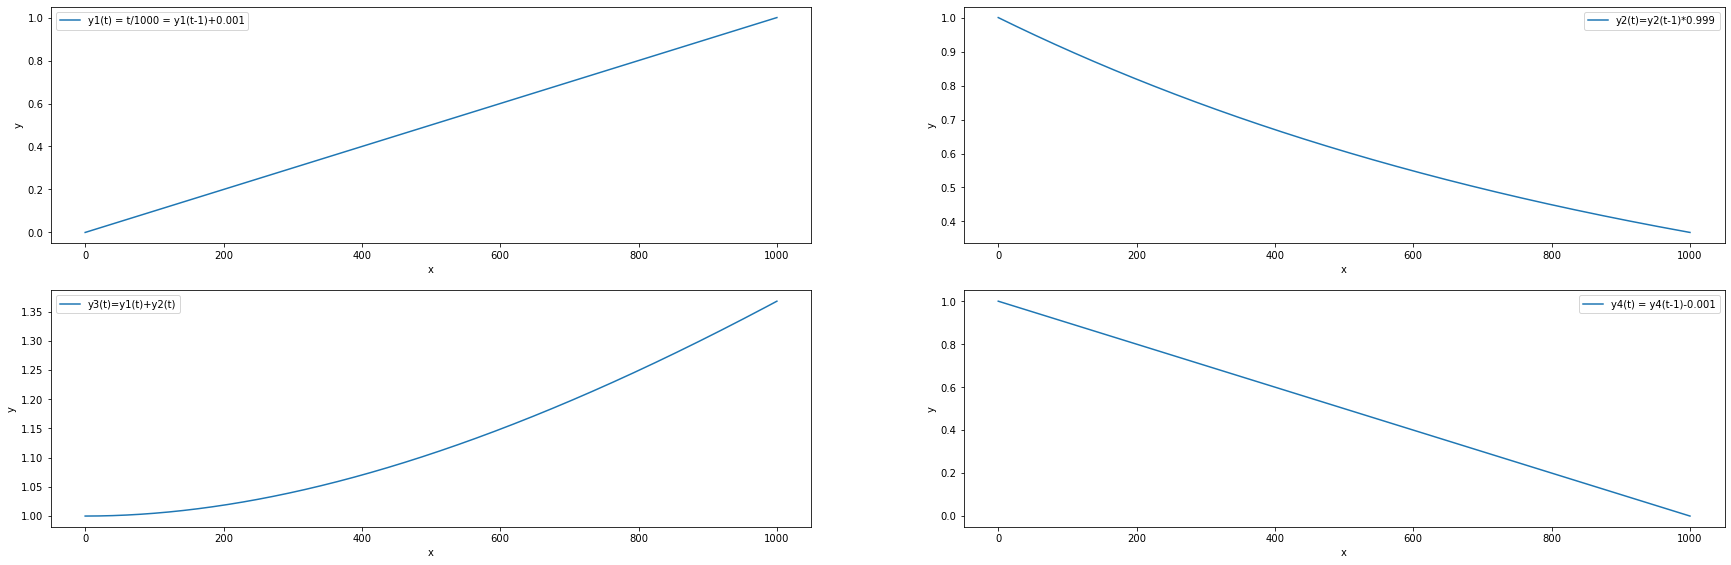

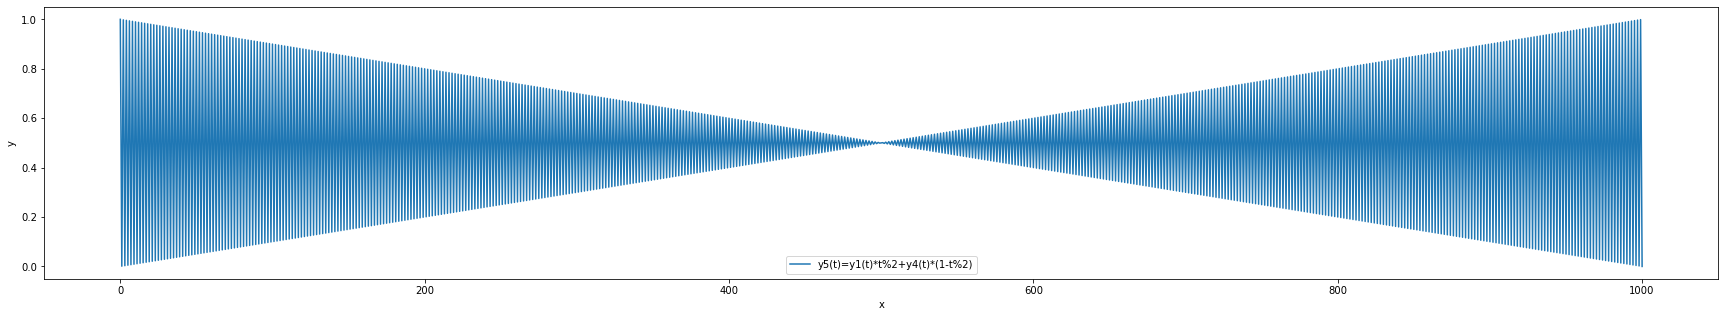

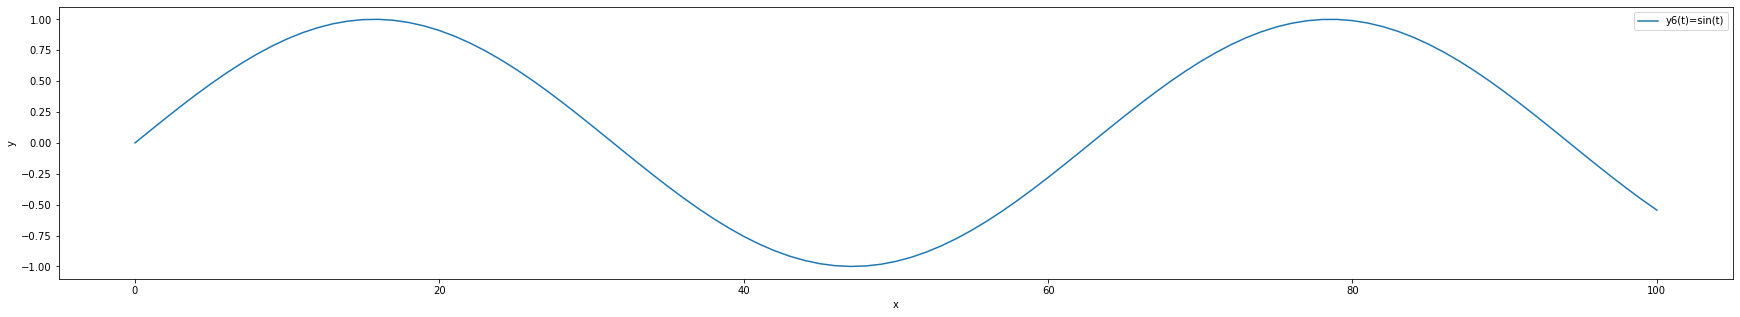

In [10]:
plt.figure(figsize=(30,20))

plt.subplot(4, 2, 1)
series1.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y1(t) = t/1000 = y1(t-1)+0.001")

plt.subplot(4, 2, 2)
series2.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y2(t)=y2(t-1)*0.999")

plt.subplot(4, 2, 3)
series3.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y3(t)=y1(t)+y2(t)")

plt.subplot(4, 2, 4)
series4.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y4(t) = y4(t-1)-0.001")

plt.figure(figsize=(30,5))
series5.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y5(t)=y1(t)*t%2+y4(t)*(1-t%2)")

plt.figure(figsize=(30,5))
series6.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y6(t)=sin(t)")

# DatasetManager e Inizializzazione Linear Regression
DatasetManager restituisce da una serie temporale un pandas.DataFrame definendo il numero di feature e il numero di variabili target.

In [11]:
class DatasetManager():
    def __getPandasFromNumpySeries(self, series, features_sequences=1, target_sequences=1, offset=0):

        dfTemp = pd.DataFrame({"ref": series})
        for i in range(target_sequences):
            dfTemp['t+'+str(target_sequences-i)] = dfTemp.ref.shift(i)

        dfTemp['t'] = dfTemp.ref.shift(target_sequences)

        for j in range(features_sequences-1):
            dfTemp['t-'+str(j+1)] = dfTemp.ref.shift(target_sequences+j+1)

        dfTemp.drop(columns=["ref"], inplace=True)
        dropLine = features_sequences+target_sequences-1

        if(offset > 0):
            dfTemp['t'] = dfTemp['t'].shift(offset)
            for i in range(features_sequences-1):
                dfTemp['t-'+str(i+1)] = dfTemp['t-'+str(i+1)].shift(offset)
        
        dfTemp.drop(np.arange(0, dropLine+offset), inplace=True)
    
        return dfTemp[dfTemp.columns[::-1]].reset_index().drop(columns=["index"])

    def __init__(self, sequences, features_sequences=1, target_sequences=1, offset=0, portion=0.8):
        self.sequences = sequences
        self.features_sequences = features_sequences
        self.target_sequences = target_sequences
        self.offset = offset
        self.portion = portion
        self.df = self.__getPandasFromNumpySeries(sequences, features_sequences, target_sequences, offset)

    def __len__(self):
        return len(self.sequences)

    def __get_columns(self):
        return self.df[self.df.columns[0:self.features_sequences]].to_numpy().astype(np.float32), self.df[self.df.columns[self.features_sequences:]].to_numpy().astype(np.float32)

    def __train_and_test_set__(self, random_state):
        xCol, yCol = self.__get_columns()
        return train_test_split(xCol, yCol, train_size=self.portion, random_state=random_state)  

    def __get_ordered_series__(self):
        return self.__get_columns()


In [12]:
def linear_regression(X_train, X_test, y_train, y_test):
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)

    y_train_pred = regressor.predict(X_train)
    y_pred = regressor.predict(X_test)
    # y_pred = y_pred.clip(min=0)
    rmse_train = RMSE_Loss(y_train, y_train_pred)

    rmse_test = RMSE_Loss(y_test, y_pred)

    correct_count = 0
    for i in range(len(y_pred)):
        if (np.rint(y_pred[i]) == y_test[i]):
            correct_count += 1
    accuracy = correct_count / len(y_test)

    return rmse_test, accuracy, y_pred, y_train_pred, rmse_train, regressor

In [18]:
def executeLinearRegression(label, series, feature_sequences=1, target_sequences=1, portion=0.8, offset=0):
    data = DatasetManager(
        series,
        features_sequences=feature_sequences,
        target_sequences=target_sequences,
        portion=portion,
        offset=offset
    )
    print("Dataset: (head - 10)")
    print(data.df.head(10))
    x_train, x_test, y_train, y_test = data.__train_and_test_set__(random_state=1)

    rmse_test, _, y_pred, y_train_predict, rmse_train, regressor = linear_regression(x_train, x_test, y_train, y_test)

    showPerformanceGraph(
        label = label+" \n RMSE_train("+str(rmse_train)+") --- RMSE_test("+str(rmse_test)+")",
        portion=portion,
        y_train=y_train.squeeze(),
        y_test=y_test.squeeze(),
        y_predicted_train=y_train_predict.squeeze(), ##get
        y_predicted_test=y_pred.squeeze(),
        loss_train=calculateResiduals(y_train.squeeze(), y_train_predict.squeeze()), ##get
        loss_test=calculateResiduals(y_test.squeeze(), y_pred.squeeze())
    )


    x_series, y_series = data.__get_ordered_series__()
    y_predicted = regressor.predict(x_series)
    plt.figure(figsize=(25,5))
    plt.plot(y_series.squeeze())
    plt.plot(y_predicted.squeeze())
    plt.legend(["True", "Predicted"])

# Esecuzione Linear Regression

In [26]:
features_length = 1 #Default 1 (Sostituire i valori per gli esperimenti)
offset = 0 #Default 0 (Sostituire i valori per gli esperimenti)
portion_train_test = 0.8 #Default 0.8 (Sostituire i valori per gli esperimenti)

Dataset: (head - 10)
       t    t+1
0  0.000  0.001
1  0.001  0.002
2  0.002  0.003
3  0.003  0.004
4  0.004  0.005
5  0.005  0.006
6  0.006  0.007
7  0.007  0.008
8  0.008  0.009
9  0.009  0.010


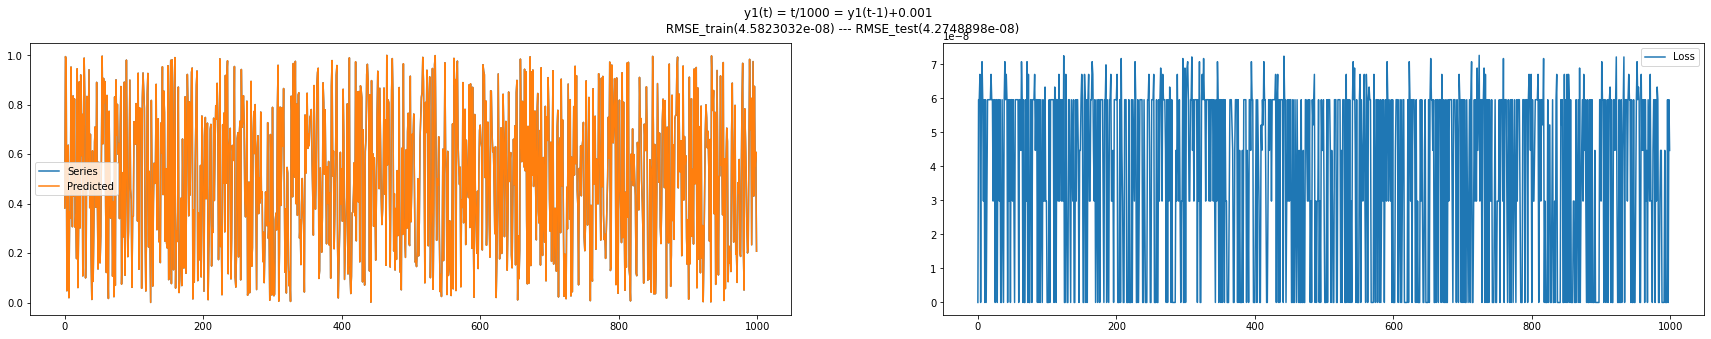

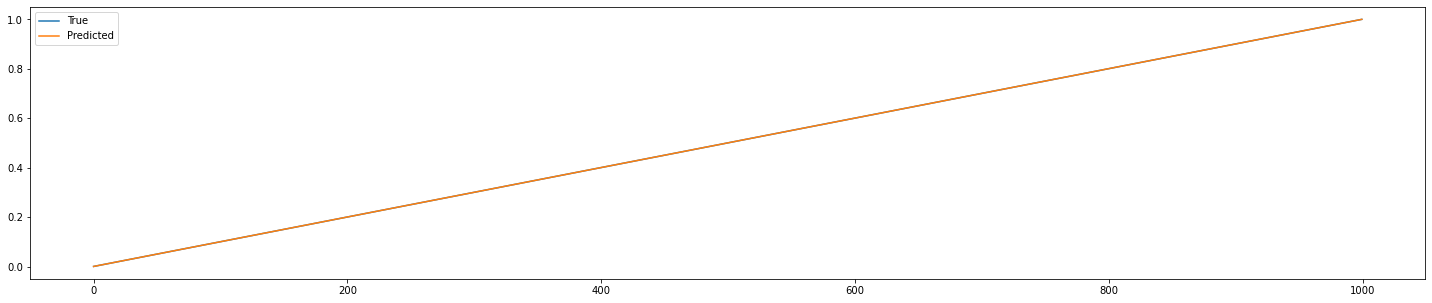

In [27]:
executeLinearRegression("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=features_length, target_sequences=1, portion=portion_train_test)

Dataset: (head - 10)
          t       t+1
0  1.000000  0.999000
1  0.999000  0.998001
2  0.998001  0.997003
3  0.997003  0.996006
4  0.996006  0.995010
5  0.995010  0.994015
6  0.994015  0.993021
7  0.993021  0.992028
8  0.992028  0.991036
9  0.991036  0.990045


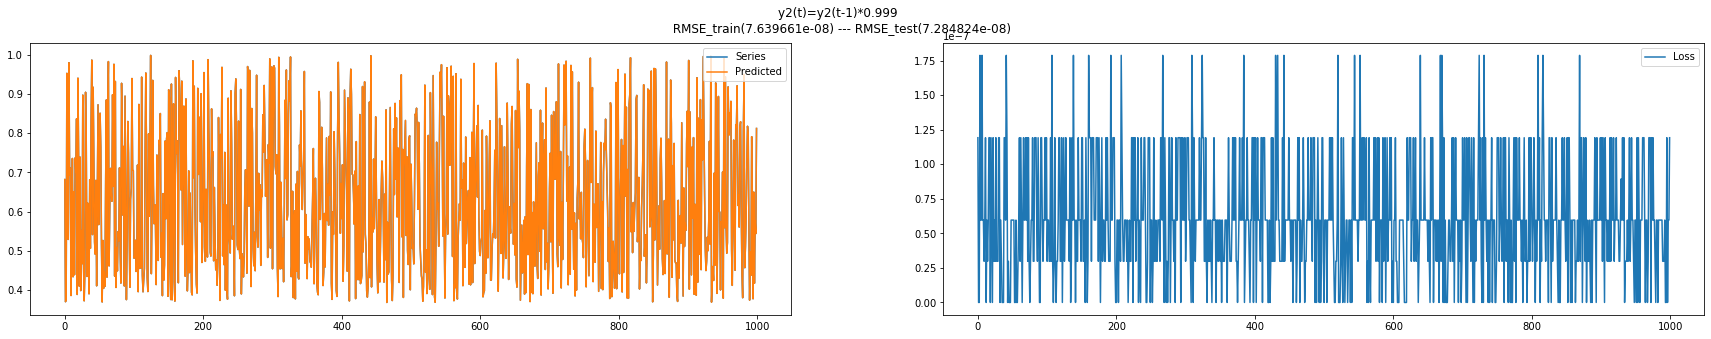

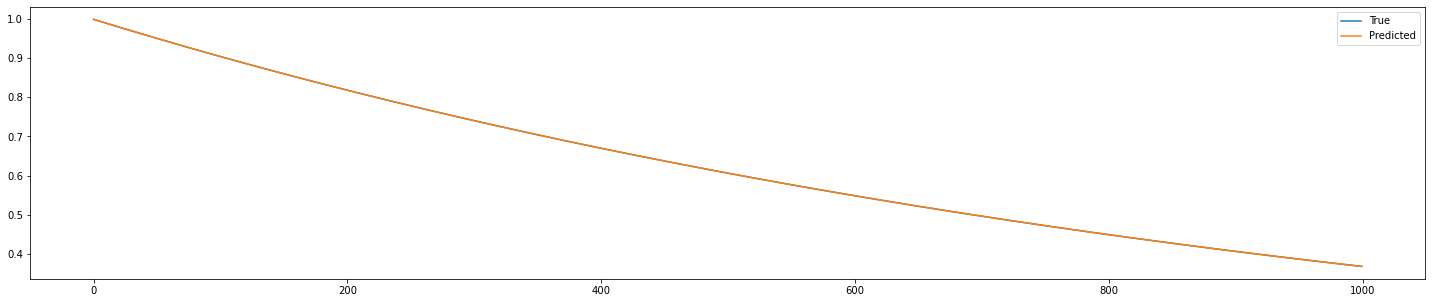

In [28]:
executeLinearRegression("y2(t)=y2(t-1)*0.999", series2, feature_sequences=features_length, target_sequences=1, portion=portion_train_test)

Dataset: (head - 10)
          t       t+1
0  1.000000  1.000000
1  1.000000  1.000001
2  1.000001  1.000003
3  1.000003  1.000006
4  1.000006  1.000010
5  1.000010  1.000015
6  1.000015  1.000021
7  1.000021  1.000028
8  1.000028  1.000036
9  1.000036  1.000045


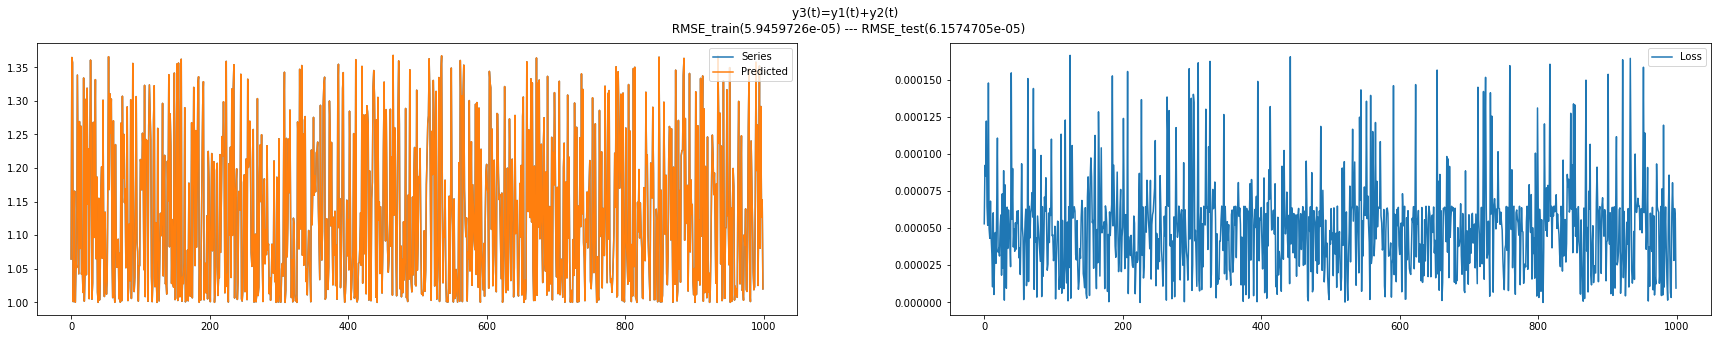

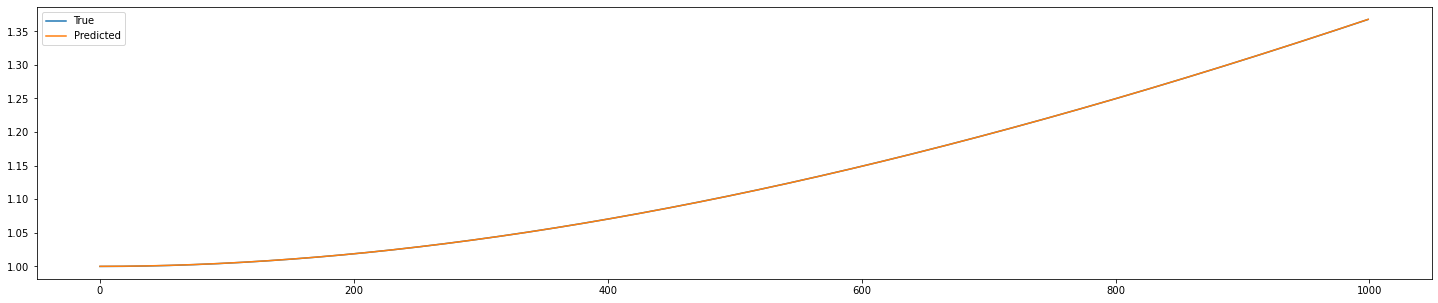

In [29]:
executeLinearRegression("y3(t)=y1(t)+y2(t)", series3, feature_sequences=features_length, target_sequences=1, portion=portion_train_test)

Dataset: (head - 10)
       t    t+1
0  1.000  0.999
1  0.999  0.998
2  0.998  0.997
3  0.997  0.996
4  0.996  0.995
5  0.995  0.994
6  0.994  0.993
7  0.993  0.992
8  0.992  0.991
9  0.991  0.990


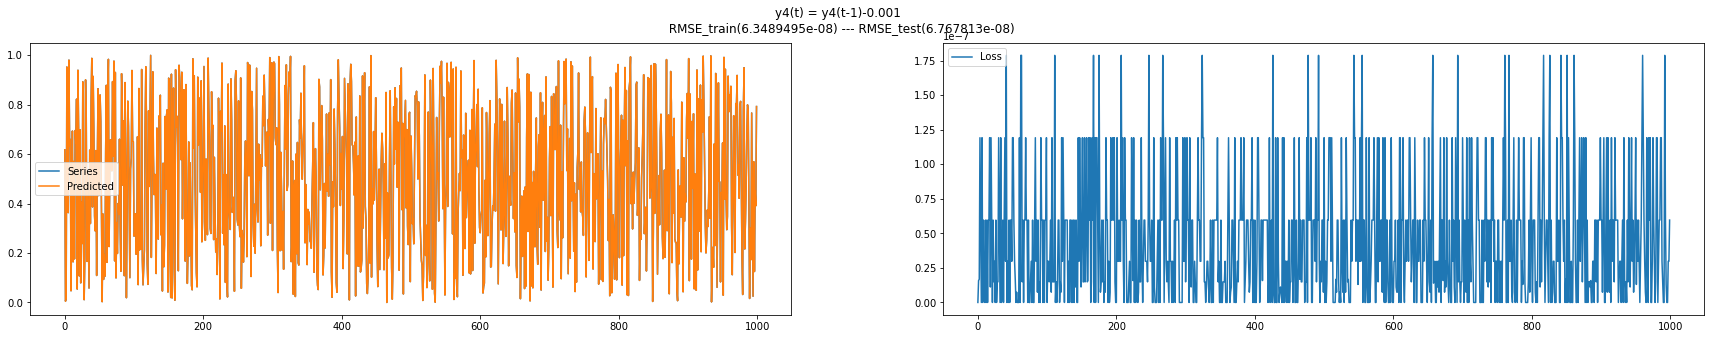

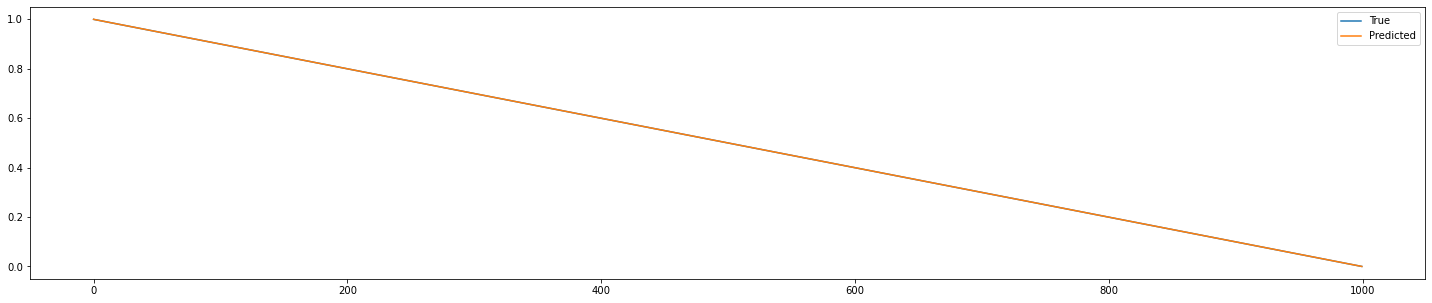

In [30]:
executeLinearRegression("y4(t) = y4(t-1)-0.001", series4, feature_sequences=features_length, target_sequences=1, portion=portion_train_test)

Dataset: (head - 10)
       t    t+1
0  1.000  0.001
1  0.001  0.998
2  0.998  0.003
3  0.003  0.996
4  0.996  0.005
5  0.005  0.994
6  0.994  0.007
7  0.007  0.992
8  0.992  0.009
9  0.009  0.990


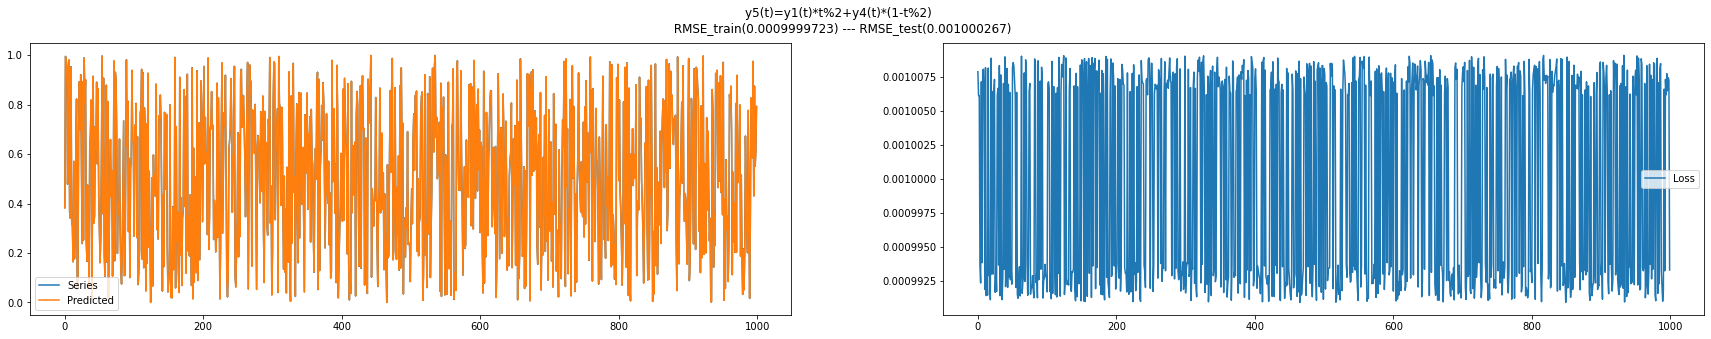

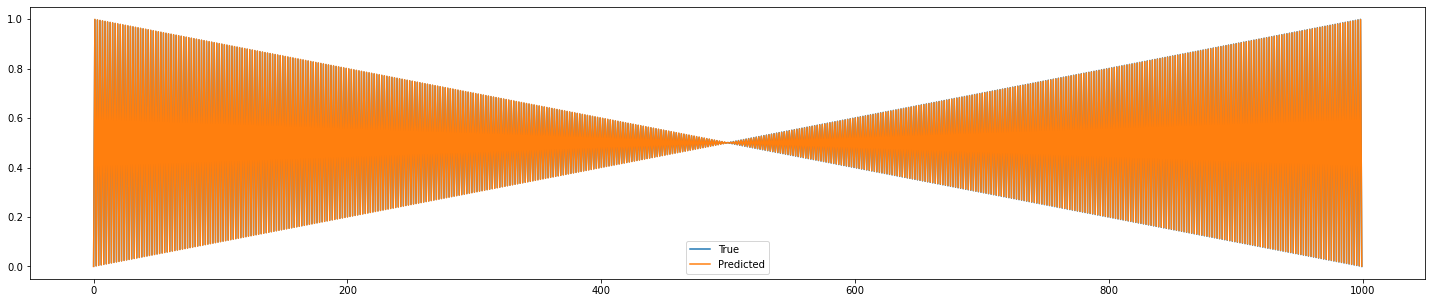

In [31]:
executeLinearRegression("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=features_length, target_sequences=1, portion=portion_train_test)

Dataset: (head - 10)
          t       t+1
0  0.000000  0.099833
1  0.099833  0.198669
2  0.198669  0.295520
3  0.295520  0.389418
4  0.389418  0.479426
5  0.479426  0.564642
6  0.564642  0.644218
7  0.644218  0.717356
8  0.717356  0.783327
9  0.783327  0.841471


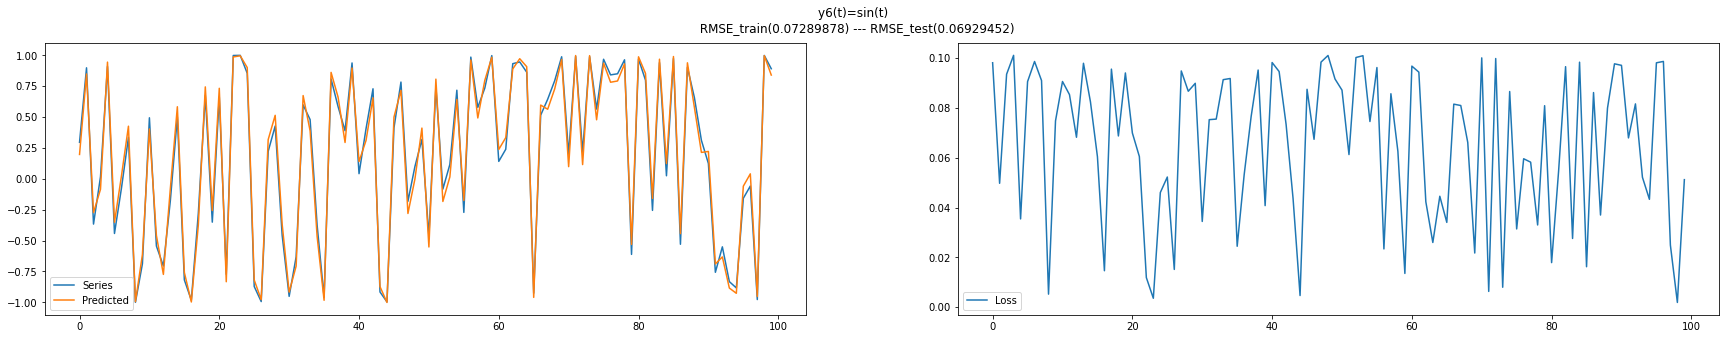

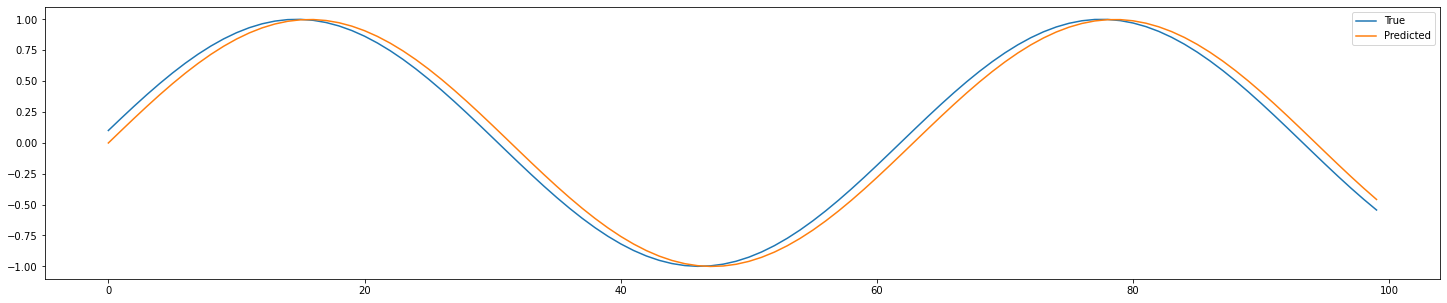

In [32]:
executeLinearRegression("y6(t)=sin(t)", series6, feature_sequences=features_length, target_sequences=1, portion=portion_train_test)